# Bike Sharing Assignment


Name : Hareshkumar.K.M

Date  : 29-Nov-2020

### DATA LOADING

#### Import requried libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

#### Read the dataset using pandas

    1. Encoding - ISO8859-1

In [2]:
day_df = pd.read_csv('day.csv' ,encoding = "ISO-8859-1")
day_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [39]:
day_df.head(5)

,yr,holiday,weekday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,winter,weather_cls2,weather_cls3
0,0,0,0,0,14.110847,18.18125,80.5833,10.749882,985,1,0,0,1,0
1,0,0,0,0,14.902598,17.68695,69.6087,16.652113,801,1,0,0,1,0
2,0,0,1,1,8.050924,9.47025,43.7273,16.636703,1349,1,0,0,0,0
3,0,0,1,1,8.200000,10.60610,59.0435,10.739832,1562,1,0,0,0,0
4,0,0,1,1,9.305237,11.46350,43.6957,12.522300,1600,1,0,0,0,0


### DATA CLEANING

#### Deleting the below list of columns with following assumptions,

1. 'instant'  - It represents only the item count which has no effect on the dataset
2. 'dteday'   - We are not performing a time series analysis , so dropping the column
3.  'mnth'    - The months are also represented in terms of 'season' columns, so dropping the same 
4. 'casual' - It represents the casual visitors, however it has not influence on the target column

5. 'registered' - It represents the registered visitors, however it has not influence on the target column


TARGET COLUMN  : 'cnt'



In [4]:
day_df= day_df.drop(['instant','dteday','mnth','registered','casual'] ,axis=1)

In [5]:
day_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      730 non-null    int64  
 1   yr          730 non-null    int64  
 2   holiday     730 non-null    int64  
 3   weekday     730 non-null    int64  
 4   workingday  730 non-null    int64  
 5   weathersit  730 non-null    int64  
 6   temp        730 non-null    float64
 7   atemp       730 non-null    float64
 8   hum         730 non-null    float64
 9   windspeed   730 non-null    float64
 10  cnt         730 non-null    int64  
dtypes: float64(4), int64(7)
memory usage: 62.9 KB


#### Visulaizing pair plots to identify the correlations

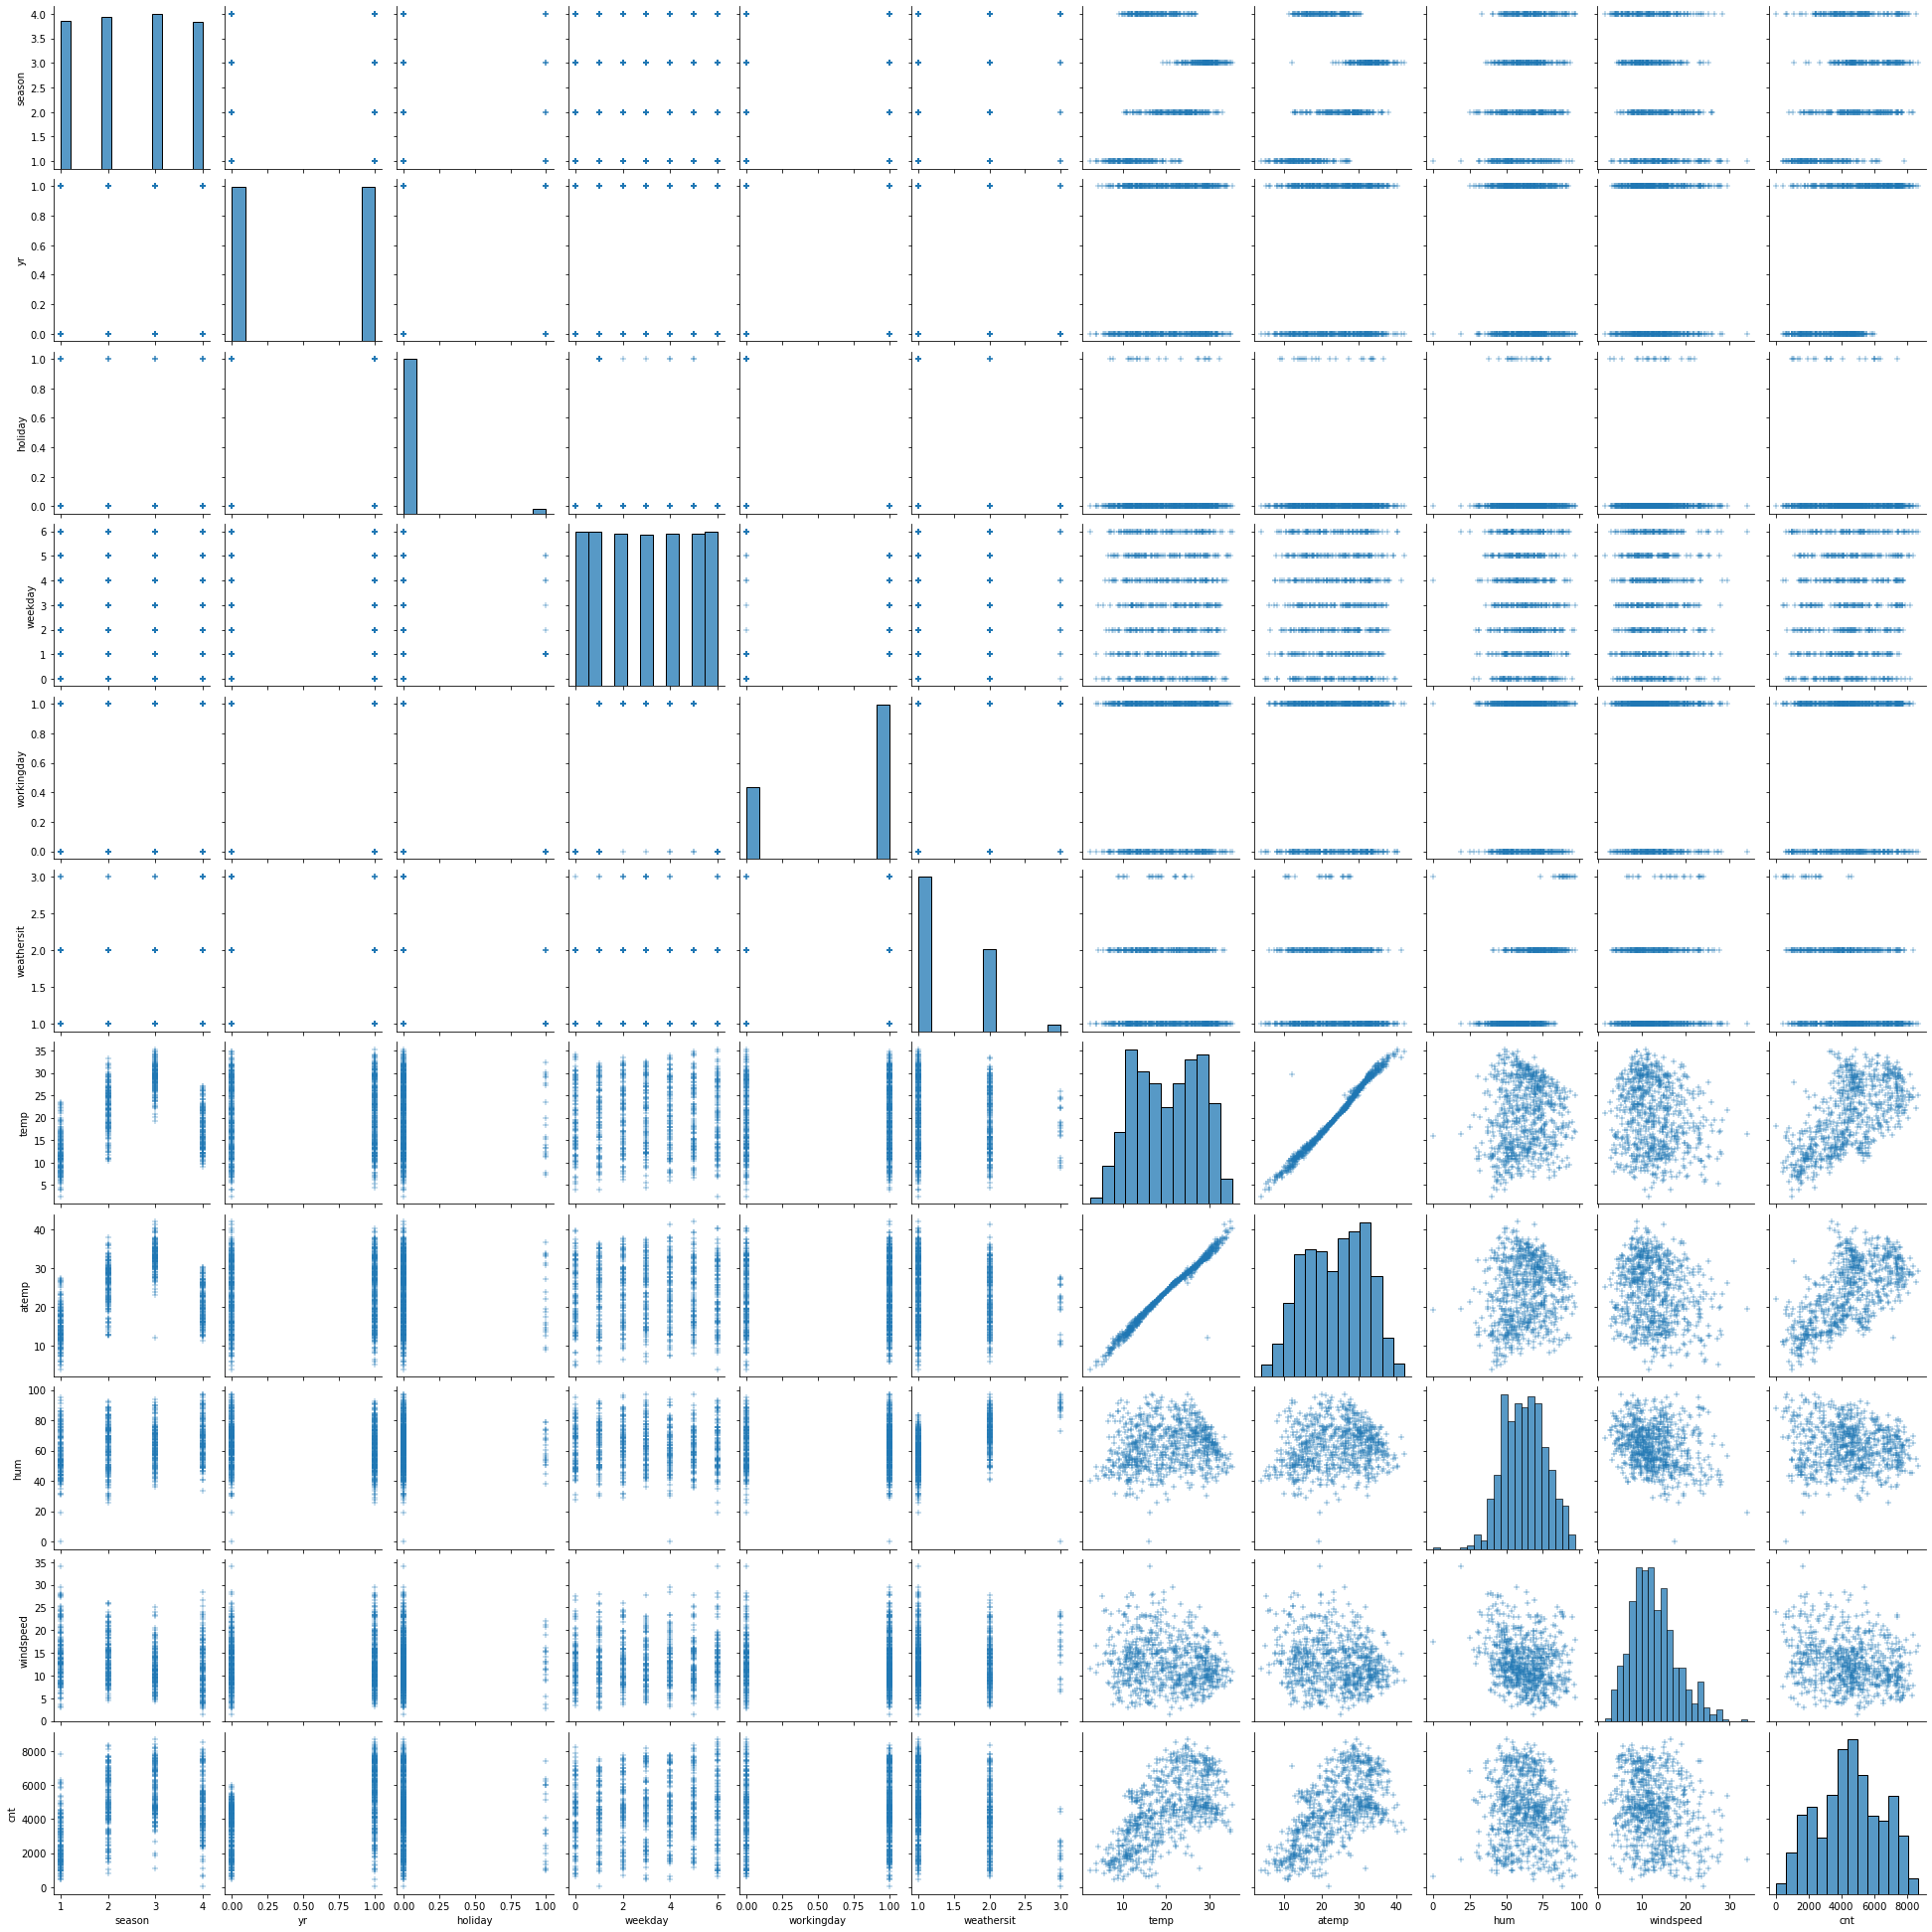

In [6]:
sns.pairplot(day_df ,markers='+')

From the above pair plot, the below list of variables are identified,

    1. CATEGORICAL variables :  season, yr, holiday, weekday,workingday,weathersit
    2. CONTINUOUS variables : temp, atemp,hum, windspeed,cnt

#### Visulaizing box plots for categorical  variables

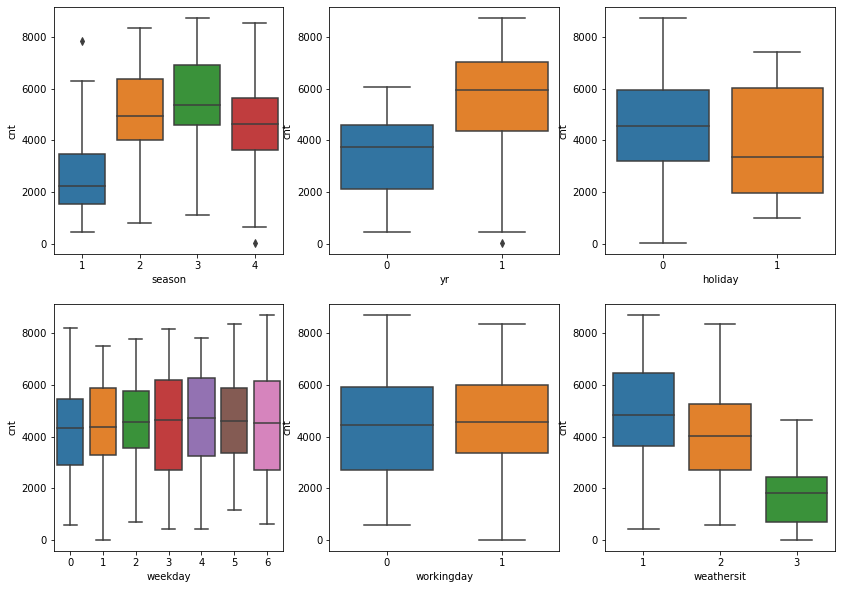

In [7]:
plt.figure(figsize=(14,10))
plt.subplot(2,3,1)
sns.boxplot(data= day_df ,x='season' ,y ='cnt')
plt.subplot(2,3,2)
sns.boxplot(data= day_df ,x='yr' ,y ='cnt')
plt.subplot(2,3,3)
sns.boxplot(data= day_df ,x='holiday' ,y ='cnt')
plt.subplot(2,3,4)
sns.boxplot(data= day_df ,x='weekday' ,y ='cnt')
plt.subplot(2,3,5)
sns.boxplot(data= day_df ,x='workingday' ,y ='cnt')
plt.subplot(2,3,6)
sns.boxplot(data= day_df ,x='weathersit' ,y ='cnt')
plt.show()

Observations from above plot:

    1.There are outliners in 'season' and 'yr' column.
    2.The outliners in the dataset ll not be deleted since feature scaling is chosen in a way that it ll not be sensitive to outliners
     

#### Visulaizing Heatmap for Continous  variables

<AxesSubplot:>

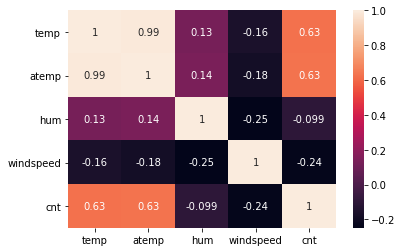

In [8]:
sns.heatmap(day_df[['temp', 'atemp','hum','windspeed','cnt']].corr(),annot=True)

#### Binning 'week days' column 

1. If the day is Saturday(6) or Sunday(0) , 'weekday' will be encoded to 0 , rest all the days encoded to 1 

In [9]:
day_df['weekday'] = day_df['weekday'].apply(lambda x: 0 if (x==6 or x==0) else 1) 

In [10]:
day_df['weekday'].value_counts()

1    520
0    210
Name: weekday, dtype: int64

#### Labelling 'season' column

    1  -'spring'
    2  -'summer'
    3  -'fall'
    4  -'winter'
    
 After label encoding is complete, it is further converted into One Hot encoding with sparse matrix structure.The resulting dataframe is concatenated to main dataframe

In [11]:
day_df['season']=day_df['season'].replace({1:'spring',2:'summer',3:'fall',4:'winter'})
day_df_season= pd.get_dummies(day_df['season'] ,drop_first=True) 
day_df = pd.concat([day_df,day_df_season],axis=1)
day_df= day_df.drop('season' ,axis=1)
day_df.head(5)


,yr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,spring,summer,winter
0,0,0,0,0,2,14.110847,18.18125,80.5833,10.749882,985,1,0,0
1,0,0,0,0,2,14.902598,17.68695,69.6087,16.652113,801,1,0,0
2,0,0,1,1,1,8.050924,9.47025,43.7273,16.636703,1349,1,0,0
3,0,0,1,1,1,8.200000,10.60610,59.0435,10.739832,1562,1,0,0
4,0,0,1,1,1,9.305237,11.46350,43.6957,12.522300,1600,1,0,0


#### Labelling 'weathersit' column

    1  -'weather_cls1'
    2  -'weather_cls2'
    3  -'weather_cls3'
    4  -'weather_cls4'
    
 After label encoding is complete, it is further converted into One Hot encoding with sparse matrix structure.The resulting dataframe is concatenated to main dataframe

In [12]:
day_df['weathersit'] = day_df['weathersit'].replace({1:'weather_cls1' ,2:'weather_cls2' ,3:'weather_cls3' ,4:'weather_cls4'  })
day_df_weather= pd.get_dummies(day_df['weathersit'] ,drop_first=True) 
day_df = pd.concat([day_df,day_df_weather],axis=1)
day_df= day_df.drop('weathersit',axis=1)
day_df.head()

,yr,holiday,weekday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,winter,weather_cls2,weather_cls3
0,0,0,0,0,14.110847,18.18125,80.5833,10.749882,985,1,0,0,1,0
1,0,0,0,0,14.902598,17.68695,69.6087,16.652113,801,1,0,0,1,0
2,0,0,1,1,8.050924,9.47025,43.7273,16.636703,1349,1,0,0,0,0
3,0,0,1,1,8.200000,10.60610,59.0435,10.739832,1562,1,0,0,0,0
4,0,0,1,1,9.305237,11.46350,43.6957,12.522300,1600,1,0,0,0,0


#### Visulaizing Heatmap after data cleaning

<AxesSubplot:>

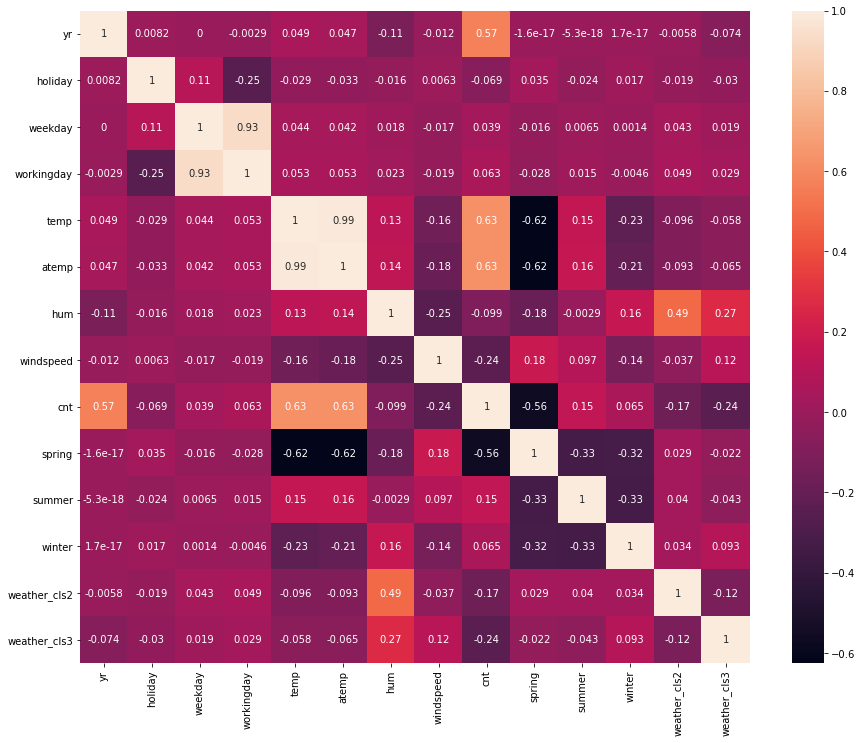

In [13]:
plt.figure(figsize=(15,12))
sns.heatmap(day_df.corr(),annot=True)

### MODEL BUILDING

#### Train test Split of dataset

    a. The trian test split is done with training dataset size of 70%  for learning  and test dataset size of 30% for evaluation
    
    b. The 'random_state' act as an index/bookmark which wil help to split the same data for training and testing when repeated multiple times

In [14]:
df_train ,df_test = train_test_split(day_df , test_size =0.3 ,random_state=60)

In [15]:
print(df_train.shape ,df_test.shape)

(511, 14) (219, 14)


#### Preparing the predictor and target datasets

In [16]:
y_train = df_train.pop('cnt')
X_train = df_train

In [17]:
print(X_train.shape ,y_train.shape)

(511, 13) (511,)


#### Feature Scaling

1. The  feature scaling is done to ensure the data values are fit within a certain boudary
2. There are two techniques to perform feature scaling  viz, 
            a.Standardization -StandardScaler()  (range : -1 to 1)
            b.Normalization -MinMaxScaler()  (range : 0 to 1)
            
3. The ideal way to scale the dataset with outler is using RobustScaler() as per 
  the link :https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html

3. However , Standardization is chosen for this assignment  since they are relatively less sesitive to existing outliners in the dataset compared to MinMaxScaler.
4. The feature scaling is applied only for continous variables and not on categorical variables
5. The feature scaling is done explicitely after the train-test split to ensure that the 'Test' dataset represents the real world data for evaluation.

In [18]:
ss_scaler = StandardScaler()
numvars = ['temp','atemp','hum','windspeed']
X_train[numvars] = ss_scaler.fit_transform(X_train[numvars])
X_train.head(5)

,yr,holiday,weekday,workingday,temp,atemp,hum,windspeed,spring,summer,winter,weather_cls2,weather_cls3
400,1,0,0,0,-1.267835,-1.294578,0.405516,-0.204572,1,0,0,1,0
450,1,0,1,1,-0.955427,-0.984220,-2.300683,-0.063826,0,1,0,0,0
142,0,0,1,1,0.719811,0.682757,1.235792,0.522616,0,1,0,1,0
368,1,0,1,1,-2.128089,-2.175792,-1.453405,-0.095153,1,0,0,1,0
231,0,0,0,0,1.077494,1.039045,0.312003,-1.103769,0,0,0,0,0


 ## Approach:
1. The regression problem has 13 different features. 
2. The top 11 features are identified using sklearn Recursive Feature elimination
3. With the  11 features, the statsmodel is used for identifyiing the best fit and r2 score

####   Using RFE to fit dataset
    1. Class name :  LinearRegression
    2. Training predictor :  X_train
    3. Training target  :y_train
    4. Final dataset after RFE :  X_train_rfe 

In [19]:
lr= LinearRegression()
lr_rfe = RFE(lr,11).fit(X_train,y_train)
lr_rfe


RFE(estimator=LinearRegression(), n_features_to_select=11)

####   Ranks of Features after fitting it with RFE

In [20]:
rfe_rank = pd.DataFrame()
rfe_rank['features'] =X_train.columns
rfe_rank['isSupported'] =lr_rfe.support_
rfe_rank['rank'] =lr_rfe.ranking_
rfe_rank = rfe_rank.sort_values('rank',ascending=True)
rfe_rank
     

,features,isSupported,rank
0,yr,True,1
1,holiday,True,1
2,weekday,True,1
3,workingday,True,1
5,atemp,True,1
6,hum,True,1
8,spring,True,1
9,summer,True,1
10,winter,True,1
11,weather_cls2,True,1


In [21]:
X_train_rfe = X_train[rfe_rank['features'][(rfe_rank['rank']==1) & (rfe_rank['isSupported'] ==True)]]

In [22]:
X_train_rfe.head(5)

,yr,holiday,weekday,workingday,atemp,hum,spring,summer,winter,weather_cls2,weather_cls3
400,1,0,0,0,-1.294578,0.405516,1,0,0,1,0
450,1,0,1,1,-0.984220,-2.300683,0,1,0,0,0
142,0,0,1,1,0.682757,1.235792,0,1,0,1,0
368,1,0,1,1,-2.175792,-1.453405,1,0,0,1,0
231,0,0,0,0,1.039045,0.312003,0,0,0,0,0


#### Defining methods for Statsmodel
 
     a. createStatsModel - It accepts the predictors and target variable to fit an OLS model


In [23]:
def createStatsModel(X,y):
    # Create Constant
    X_sm = sm.add_constant(X)
    lr = sm.OLS(y,X_sm)
    lr_model=lr.fit()
    return lr_model
    

     b. calculateVIF - It accepts the predictors and calculates the Variable Inflation factor

In [24]:
def calculateVIF(X):
    vif = pd.DataFrame()
    vif['features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values,i)  for i in range(X.shape[1])]
    vif =vif.sort_values('VIF' ,ascending =False)
    return vif

In [25]:
iterationcycles ={}

##### Iteration 1: 
1. Training  the selected dataset X_train_rfe with stats model containing top 11 features
2. Dropping columns whose P value is large 
3. Dropping columsn whose VIF is large.
4. Repteating the iterations until the PValue and VIF are stable with no significant reduction in r2 score

In [26]:
lr_model = createStatsModel(X_train_rfe,y_train)
print(lr_model.summary())
iterationcycles.update({'iter1':lr_model.rsquared})
print('VIF : ')
print(calculateVIF(X_train_rfe))


                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     249.2
Date:                Sun, 29 Nov 2020   Prob (F-statistic):          4.49e-187
Time:                        21:46:41   Log-Likelihood:                -4143.3
No. Observations:                 511   AIC:                             8309.
Df Residuals:                     500   BIC:                             8355.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         3641.4323    123.621     29.457   

##### Iteration 2: 
1. Drop the 'holiday' column since it has 'inf' value for VIF

In [27]:
X_train_rfe= X_train_rfe.drop('holiday',axis=1)
lr_model = createStatsModel(X_train_rfe,y_train)
print(lr_model.summary())
iterationcycles.update({'iter2':lr_model.rsquared})
print('VIF : ')
print(calculateVIF(X_train_rfe))


                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     249.2
Date:                Sun, 29 Nov 2020   Prob (F-statistic):          4.49e-187
Time:                        21:46:42   Log-Likelihood:                -4143.3
No. Observations:                 511   AIC:                             8309.
Df Residuals:                     500   BIC:                             8355.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         3641.4323    123.621     29.457   

##### Iteration 3: 
1. Drop the 'weekday' column since it has 26.6' value for VIF

In [28]:
X_train_rfe= X_train_rfe.drop('weekday',axis=1)
lr_model = createStatsModel(X_train_rfe,y_train)
print(lr_model.summary())
iterationcycles.update({'iter3':lr_model.rsquared})
print('VIF : ')
print(calculateVIF(X_train_rfe))


                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     269.6
Date:                Sun, 29 Nov 2020   Prob (F-statistic):          1.06e-185
Time:                        21:46:43   Log-Likelihood:                -4149.4
No. Observations:                 511   AIC:                             8319.
Df Residuals:                     501   BIC:                             8361.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         3569.9563    123.262     28.962   

##### Iteration 3: 
1. Drop the 'summer' column since it has large p value of 0.073
2. The assumption is any p value < 0.05 is nominal

In [29]:
X_train_rfe= X_train_rfe.drop('summer',axis=1)
lr_model = createStatsModel(X_train_rfe,y_train)
print(lr_model.summary())
iterationcycles.update({'iter4':lr_model.rsquared})
print('VIF : ')
print(calculateVIF(X_train_rfe))

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     301.5
Date:                Sun, 29 Nov 2020   Prob (F-statistic):          2.93e-186
Time:                        21:46:43   Log-Likelihood:                -4151.1
No. Observations:                 511   AIC:                             8320.
Df Residuals:                     502   BIC:                             8358.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         3707.5200     96.720     38.332   

##### Plotting the  r2 values over cycles

1. It is observed that the r2 score has very minimal impact over the iteration process
2. Training accuracy :  82.8%


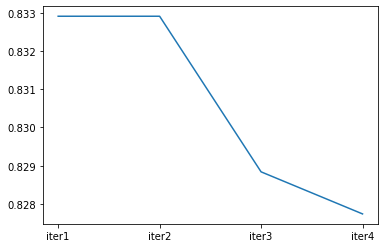

In [30]:
plt.plot(iterationcycles.keys(),iterationcycles.values())

#### Preparing for evaluation of Model
 
     1. The test dataset is scaled with StandardScaler for continuous variable
     2. Please note that the test set is tranformed and not fit_transformed  
     3. Creating X_test and y_test 
     4. Adding constants to predictor test set
     5. Dropping features in X_test dataset to march X_train set


In [31]:
df_test[numvars] = ss_scaler.transform(df_test[numvars])
y_test = df_test.pop('cnt')
X_test = df_test
X_test_sm = sm.add_constant(X_test)



In [32]:
X_test_sm = X_test_sm.drop(['holiday','weekday','temp','windspeed','summer'] ,axis=1)

#### Evaluation of Model

1. Predicting the target counts 'cnt' using the test set
2. Peforming resisual analysis
3. Evaluating the test  r2_score
4. The assumption that the mean of the residuals is always 0  the linear regression is  hence proved by the distribution plot 

In [33]:
y_test_pred = lr_model.predict(X_test_sm)
res = y_test -y_test_pred
print(r2_score(y_test,y_test_pred))


0.7575479382519208


#### Assumptions for Linear Regression
    1. The mean of residuals for an LR model is always 0 

<AxesSubplot:ylabel='Density'>

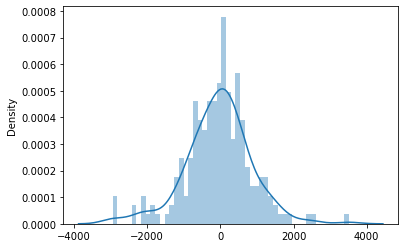

In [34]:
sns.distplot(res,bins=50)

### CONCLUSION

 Training R2 score : 82.8%
 
 Test R2 score :  75.75%